# Ramping tests

**AIM**: To find the appropriate ramp slope for P1 that keeps the gate voltage "constant".

Based upon `june/toolkit_example_code/psb_gate_sequence.ipynb` which is based upon `june/toolkit_example_code/lf_st_sweep.ipynb` respectively

In [1596]:
%matplotlib inline
import local_broom

In [1597]:
from zhinst.toolkit import Session, CommandTable, Sequence, Waveforms, SHFQAChannelMode

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import time
from monty import Monty

## Setup

In [1598]:
# connect to instruments

DEVICE_ID = 'DEV12158'
SERVER_HOST = 'localhost'

# connect to data server
session = Session(SERVER_HOST)

# connect to device
device = session.connect_device(DEVICE_ID)

In [1621]:
#session.disconnect_device(DEVICE_ID)

In [1600]:
experiment = {
    "desc": "Find the optimal ramp rate."
}

monty = Monty("rf.ramp rate", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 31


### Variables

In [1601]:

# gate sampling time
samplingDivider = 9

# readout signals
readout_gain = 0.95  # If we set this to 1, then output overloads
readout_freq = 406.6e6  # (Hz)

# drive line amplitudes (maximum 340mV, give in terms of V)
#init_amp = 0.02 * 10  # *10 compensates weird quirk between interaction of voltToDbm function, pulseAndRamp array, and SHFQC behaviour...
read_amp = 0.2
#read_amp_j = 0.2

ramp_rate = 0 #1e-5  # 6.8e-6  # hopefully this is calibrated to 250 MHz sample rate (V/s)
num_pulses = 65  # number of unique waveforms to generate
averages = 1  # python averages
seq_averages = 2000  # seqc averages

# timings in seconds
wait_and_settle = 2e-3  # C time
prior_delay = 10e-6  # A time
init_len = 10e-6      # starting P1/P2 pulse length (B time)
read_len = 20e-6       # readout pulse length (D time)
max_pulse_length = 1e-3

### Functions

In [1602]:
def timeToSamples(time, samplingRateDivider):
    # returns the number of samples divisible by 16 given a time (in seconds) and sampling rate divider
    samples_raw = time * (1/(2**samplingRateDivider))/0.5e-9
    samples_modulo = int(samples_raw) % 16
    samples = int(samples_raw) - int(samples_modulo)
    return samples

# custom curve fit
amps = [1, 0.85, 0.75, 0.65,  0.5, 0.35, 0.25, 0.2, 0.125, 0.05]
voltages = [0.34, 0.268, 0.207, 0.158, 0.094, 0.0481,  0.026, 0.0183, 0.01, 0.0057]

alt_fit = np.poly1d(np.polyfit(amps, voltages, 2))
# Hard coding alt_fit values in case something goes horribly wrong

def voltToDbm(volt, dbmrange):
    # Ok yes this can be better, deal with it
    if dbmrange != 0:
        raise Exception("This function only works with a dBm range of 0.")
    
    if volt > 0.34 or volt < -0.34:
        raise ValueError(f"Given voltage ({volt} V) is greater than max output of SHFQC (0.34 V)")
    
    if volt < 0:
        amplitude = 1/300*(np.sqrt(3e5*-volt + 529) - 23)
        return -amplitude
    else:
        amplitude = 1/300*(np.sqrt(3e5*volt + 529) - 23)
        return amplitude


def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            print(captured_data)
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1:  # readout 1 point
                wave_data_captured[node] = True
                # total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data

In [1603]:
voltToDbm(0,0)

0.0

### Setup channels

In [1604]:
# Create channel maps for simplicity

chan = {
    "measure": device.qachannels[0],  # measure and acquire lines
    "P1": device.sgchannels[1],  # drive P1 line
    "P2": device.sgchannels[2],  # drive P2 line
}

drive_chans = ["P1", "P2"]  # match keys above

In [1605]:
with device.set_transaction():
    for c in drive_chans:
        chan[c].output.range(0)  # in dBm
        chan[c].output.rflfpath(0)  # use LF not RF (1 for RF)
    
        # set the center synth frequency (oscillator frequency)
        synth = chan[c].synthesizer()
        device.synthesizers[synth].centerfreq(0)  # in Hz
        chan[c].output.on(1)  # enable output
    
        chan[c].awg.outputamplitude(1.0)  # overall amplitude scaling factor (don't really need to change)
        chan[c].oscs[0].freq(0)  # oscillator 1 frequency (Hz) disable for DC
        chan[c].oscs[1].freq(0)  # oscillator 2 frequency (Hz)
        chan[c].awg.modulation.enable(1)  # start digital modulation
    
        chan[c].marker.source(0)  # setup the AWG trigger 1 (is this an input trigger option? doesn't seem necessary)
        # see manual page p235 for all trigger options
        chan[c].awg.auxtriggers[0].channel(8)  # 8=use internal trigger, 1024=use software trigger

    chan["measure"].output.rflfpath(0)  # use LF mode not RF (for signals under 600Mhz)
    chan["measure"].input.rflfpath(0)
    chan["measure"].oscs[0].freq(readout_freq)  # CW frequency (in LF mode)
    chan["measure"].oscs[0].gain(readout_gain)  # If we set this to 1, then output overloads

    # configure these based on how the sweeper works internally
    # See https://docs.zhinst.com/zhinst-utils/en/latest/_modules/zhinst/utils/shf_sweeper.html#ShfSweeper
    chan["measure"].spectroscopy.delay(0)  # integration delay in units of second
    chan["measure"].spectroscopy.length(timeToSamples(read_len, samplingDivider))  # integration time length in units of number of samples (usually integration_time*sampling_rate)
    # setup when the spectroscopy is triggered
    chan["measure"].spectroscopy.trigger.channel("chan0seqtrig0")  # make sure to use the trigger coming from the sequencer code
    # setup result parameters
    chan["measure"].spectroscopy.result.averages(1)  # number of averages (always average in software not hardware)
    chan["measure"].spectroscopy.result.length(num_pulses*seq_averages)  # number of results
    chan["measure"].spectroscopy.result.enable(0)  # disable result logger

    chan["measure"].configure_channel(
        center_frequency=0,  # in units of Hz  # minimum of 600MHz
        input_range=-10,  # in units of dBm
        output_range=-10,  # in units of dBm
        mode=SHFQAChannelMode.SPECTROSCOPY,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
    )
    
    chan["measure"].input.on(1)
    chan["measure"].output.on(1)

    chan["measure"].generator.auxtriggers[1].channel("inttrig")

    chan["measure"].generator.configure_sequencer_triggering(
        aux_trigger=8,  # alternatively use 8=internal trigger, or "software_trigger0" to use the software triggering system
        play_pulse_delay=0
    )


### Create ramp pulses

**TODO**: Upload different ramp shapes with longer and longer durations.

Ramp pulses from $10\mu s$ to $100 \mu s$ long. Keep the same slope for each

In [1606]:
pulse_lens = np.linspace(2*read_len, max_pulse_length, num_pulses)

# define waveforms as list of real-values arrays
waves = []
for p_len in pulse_lens:
    samples = timeToSamples(p_len, samplingDivider)
    wv = np.linspace(voltToDbm(read_amp, 0), voltToDbm(read_amp+read_amp*samples*ramp_rate, 0), samples)
    #wv = np.linspace(read_amp, read_amp, samples)
    waves.append(wv) # / np.max(wv))

print(waves)

[array([0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214, 0.7434214,
       0.7434214, 0.7434214, 0.7434214, 0.7434214,

In [1607]:
# test to make sure that our pulses are not greater than 1
# otherwise the SHFQC will loop back to playing -1 instead!

if np.max([np.max(w) for w in waves]) > 1:
    raise ValueError(f"Wave amplitude too high {[np.max(w) for w in waves]}")

if np.min([np.min(w) for w in waves]) < -1:
    raise ValueError("Wave amplitude too low")

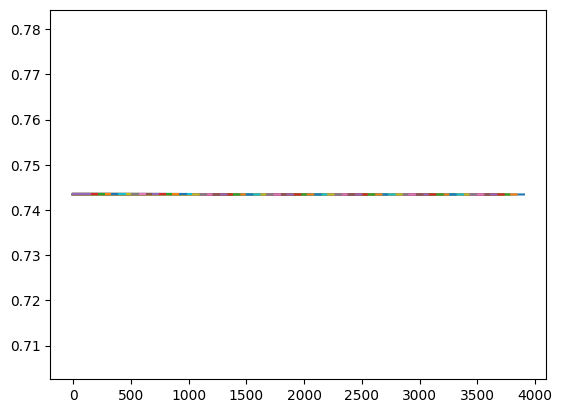

In [1608]:
# sanity check
# waves.reverse()
for i in waves[::-1]:
    plt.plot(i)

### Define sequences

In [1609]:
# use the same waveforms for all sequence programs
p_prog_code = f"""
// Reset the oscillator phase
resetOscPhase();

repeat({seq_averages}) {{
    for (var i = 0; i < {num_pulses+1}; i++) {{
        // Trigger the scope
        waitDigTrigger(1);
        setTrigger(1);
        setTrigger(0);
    
        playZero({timeToSamples(prior_delay, samplingDivider)}, {samplingDivider}); // A
        playZero(32, {samplingDivider});
        executeTableEntry(i);  // B
        //playZero({timeToSamples(wait_and_settle, samplingDivider)}, {samplingDivider}); // C
    }}
}}
"""

# How much longer to delay each repeated pulse
#pulse_len_step_samples = timeToSamples(pulse_lens[1]-pulse_lens[0], samplingDivider)

readout_prog_code = f"""
setTrigger(0); // Set low as this starts the spectroscopy readout....

cvar samples_raw = {(pulse_lens[1]-pulse_lens[0])*(1/(2**samplingDivider))/0.5e-9};

repeat({seq_averages}) {{
    for (cvar i = 0.0; i < {num_pulses+1}; i++) {{
        // wait for a digital trigger before starting (defined by the aux_trigger)
        waitDigTrigger(1);
    
        // lineup with SG trigger
        playZero(224); // time before readout A (224 samples = lines up with SG trigger)
        
        // Section A
        playZero({timeToSamples(prior_delay, samplingDivider)}, {samplingDivider});
    
    
        // Section B
        playZero(floor((i+1)*samples_raw / 16)*16, {samplingDivider});
    
        // Section D
        // set trigger output 1 to 1 then 0. As this matches "chan0seqtrig0" the spectroscopy is started
        playZero({timeToSamples(pulse_lens[0]-read_len, samplingDivider)}, {samplingDivider});
        //playZero({timeToSamples(read_len, samplingDivider)}, {samplingDivider}); // readout
        playZero(32, {samplingDivider});
        setTrigger(1);
        setTrigger(0);
    
    
        // Section C
        //playZero({timeToSamples(wait_and_settle, samplingDivider)}, {samplingDivider});     // wait and settle
    }}
}}
"""

In [1610]:
timeToSamples(pulse_lens[0]-read_len, samplingDivider)
print(pulse_lens[0])

4e-05


In [1611]:
# upload waveforms to instrument

# upload drive code
for channel in [chan["P1"], chan["P2"]]:
    seq = Sequence()
    seq.code = p_prog_code
    seq.waveforms = Waveforms()
    for i, wave in enumerate(waves):
        seq.waveforms[i] = wave.copy()

    channel.awg.load_sequencer_program(seq)
    channel.awg.write_to_waveform_memory(seq.waveforms)

    print(f"_________ {channel} _________")
    print(seq.code)
    
# upload with sequence code as the memory must be allocated first

# upload measure code
print("_________  READOUT  _________")
print(readout_prog_code)
print(chan["measure"].generator.load_sequencer_program(readout_prog_code))

_________ /dev12158/sgchannels/1 _________

// Reset the oscillator phase
resetOscPhase();

repeat(2000) {
    for (var i = 0; i < 66; i++) {
        // Trigger the scope
        waitDigTrigger(1);
        setTrigger(1);
        setTrigger(0);
    
        playZero(32, 9); // A
        playZero(32, 9);
        executeTableEntry(i);  // B
        //playZero(7808, 9); // C
    }
}

_________ /dev12158/sgchannels/2 _________

// Reset the oscillator phase
resetOscPhase();

repeat(2000) {
    for (var i = 0; i < 66; i++) {
        // Trigger the scope
        waitDigTrigger(1);
        setTrigger(1);
        setTrigger(0);
    
        playZero(32, 9); // A
        playZero(32, 9);
        executeTableEntry(i);  // B
        //playZero(7808, 9); // C
    }
}

_________  READOUT  _________

setTrigger(0); // Set low as this starts the spectroscopy readout....

cvar samples_raw = 58.59374999999999;

repeat(2000) {
    for (cvar i = 0.0; i < 66; i++) {
        // wait for a digital trigger be

#### Verify sequences

In [1612]:
loaded_waveforms = chan["P1"].awg.read_from_waveform_memory()

loaded_waveforms.validate(chan["P1"].awg.waveform.descriptors())

#### Setup command tables
**TODO**: Rewrite this into a function that takes the channel name

In [1613]:
# COMMAND TABLES

def cmdtable(ct, amplitude, length, wave_index, ct_index):
    """
    Load a default command table with a sin/cos wave (used throughout the documentation)
    """
    ct.table[ct_index].waveform.index = wave_index
    ct.table[ct_index].amplitude00.value = amplitude  # all in dBm
    ct.table[ct_index].amplitude01.value = -amplitude
    ct.table[ct_index].amplitude10.value = amplitude
    ct.table[ct_index].amplitude11.value = amplitude
    ct.table[ct_index].waveform.length = length  # in samples
    ct.table[ct_index].waveform.samplingRateDivider = samplingDivider  # inherit global


# each pulse needs its own command table
for channel in [chan["P1"], chan["P2"]]:
    schema = channel.awg.commandtable.load_validation_schema()
    ct = CommandTable(schema)

    #ct.active_valitation = True
    for wave_index in range(num_pulses):
        cmdtable(ct,
                 amplitude= voltToDbm(read_amp, channel.output.range()),
                 length=timeToSamples(max_pulse_length, samplingDivider),
                 wave_index=wave_index,
                 ct_index=wave_index,
                )
    channel.awg.commandtable.upload_to_device(ct)

In [1614]:
read_amp

0.2

### Setup internal trigger

In [1615]:
device.system.internaltrigger.repetitions(num_pulses*seq_averages)  # make sure that this matches how many pulses we are sending
device.system.internaltrigger.holdoff(2e-3)  # init_len + 2*wait_and_settle + 100e-6*2)  # how long to wait between retriggers (increments of 100ns)

## Run

In [1616]:
# setup channel synchronization
chan["measure"].synchronization.enable(1)
chan["P1"].synchronization.enable(1)
device.system.internaltrigger.synchronization.enable(1)

Started new run p1_sweep.31


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run finished and took 0:04:22.001232.
Saving to p1_sweep.31.xz
Saving to experiment.yaml


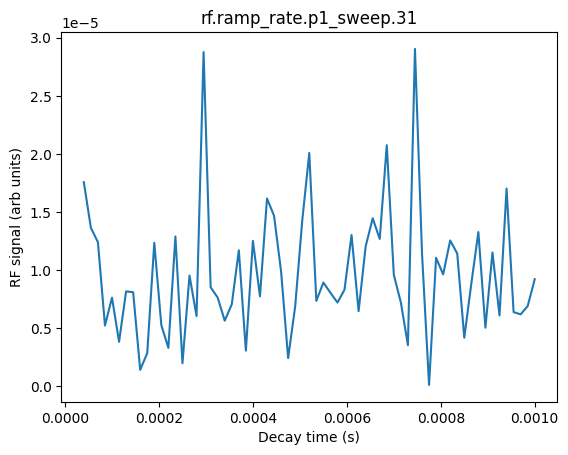

In [1617]:
data = np.zeros((averages, num_pulses), dtype=np.complex64)

monty.newrun("p1 sweep", {})

for avg in tqdm(range(averages)):
    #print(f"AVG={avg}")
    device.system.internaltrigger.enable(0)
    
    result_node = chan["measure"].spectroscopy.result.data.wave
    result_node.subscribe()
    
    chan["measure"].spectroscopy.result.enable(1)  # start logger
    
    # start sequencers
    chan["measure"].generator.enable_sequencer(single=True)
    chan["P1"].awg.enable_sequencer(single = 1)  # dont want to repeat
    #chan["P2"].awg.enable_sequencer(single = 1)
    
    # start triggering sequence (which starts each sequencer)
    device.system.internaltrigger.enable(1)
    time.sleep(0.1)
    
    # wait for the measurement to complete
    tic = time.time()
    pbar = tqdm(total=100)
    while device.system.internaltrigger.progress() != 1.0:
        p = int(device.system.internaltrigger.progress()*100)
        pbar.update(p-pbar.n)
        time.sleep(0.001)
    pbar.update(100-pbar.n)
    pbar.close()
    #print(time.time()-tic)

    # time.sleep(0.1)
    m_state = chan["measure"].generator.sequencer.status()
    p1_state = chan["P1"].awg.sequencer.status()
    if m_state != 4 and p1_state != 4:
        print(TimeoutError(f"Sequencers in unknown state. Perhaps they are not synchronised? {m_state}, {p1_state}"))
        time.sleep(0.5)
    
    # chan["measure"].spectroscopy.result.enable(0)  # stop data logger
    
    #device.system.internaltrigger.enable(0)

    # wait for completion
    while chan["measure"].spectroscopy.result.enable() != 0:
        chan["measure"].spectroscopy.result.enable.wait_for_state_change(0, timeout=10)

    
    # get results
    results = get_results(result_node, timeout=5)
    result_node.unsubscribe()

    # verify results
    acq = chan["measure"].spectroscopy.result.acquired()
    if len(results) > acq:
        print(chan["measure"].generator.ready())
        print(chan["P1"].awg.ready())
        print(bin(chan["measure"].generator.sequencer.status()))
        print(bin(chan["P1"].awg.sequencer.status()))

        # Status of the Sequencer on the instrument.
        # Bit 0: Sequencer is running;
        # Bit 1: reserved;
        # Bit 2: Sequencer is waiting for a trigger to arrive;
        # Bit 3: Sequencer has detected an error;
        # Bit 4: sequencer is waiting for synchronization with other channels
        raise TimeoutError(f"Not all datapoints measured in the time provided. {acq} of {len(results)}.")

    # remove sequence averaging
    data[avg] = np.mean(results.reshape((seq_averages, num_pulses)), axis=0)

time.sleep(1)
chan["measure"].input.on(0)
chan["measure"].output.on(0)

res = np.mean(data, axis=0)
plt.plot(pulse_lens, np.abs(res))
plt.xlabel("Decay time (s)")
plt.ylabel("RF signal (arb units)")
plt.title(monty.identifier + "." + monty.runname)

monty.save({"data": res})
monty.savefig(plt, "ramp decay")

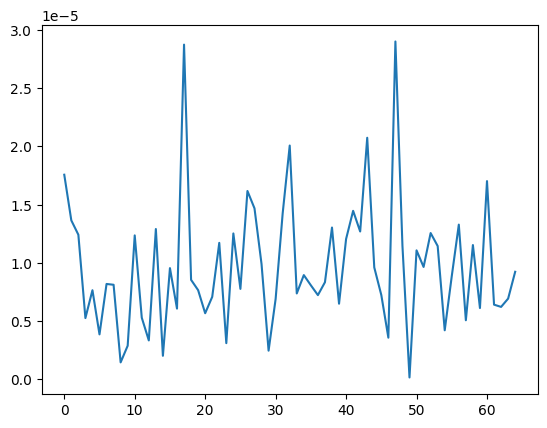

In [1618]:
plt.plot(np.abs(res))

In [1619]:
print(np.shape(data))

(1, 65)


In [1620]:
 device.system.internaltrigger.progress()

1.0